In [10]:
from IPython.display import Image
import os
import shutil
import random
import datetime

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import mixed_precision

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

#Problem Definition

> Training a model to classify different types of skin cancer.

#What kind of data do we have?

> This dataset was sourced from [Kaggle](https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic)

> The data set contains the following diseases:
* actinic keratosis
* basal cell carcinoma
* dermatofibroma
* melanoma
* nevus
* pigmented benign keratosis
  -seborrheic keratosis
* squamous cell carcinoma
* vascular lesion

#Success Definition

> The model being able to differentiate between different types of skin cancer with an accuracy >95% on unseen data.

In [11]:
#Setting up mixed precision
mixed_precision.set_global_policy('mixed_float16')

#Global Variables
IMG_SIZE = (224,224)

#Defining train and test directories

train_dir = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size = IMG_SIZE, label_mode = 'categorical')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size = IMG_SIZE, label_mode='categorical', shuffle=False)

Found 2239 files belonging to 9 classes.
Found 118 files belonging to 9 classes.


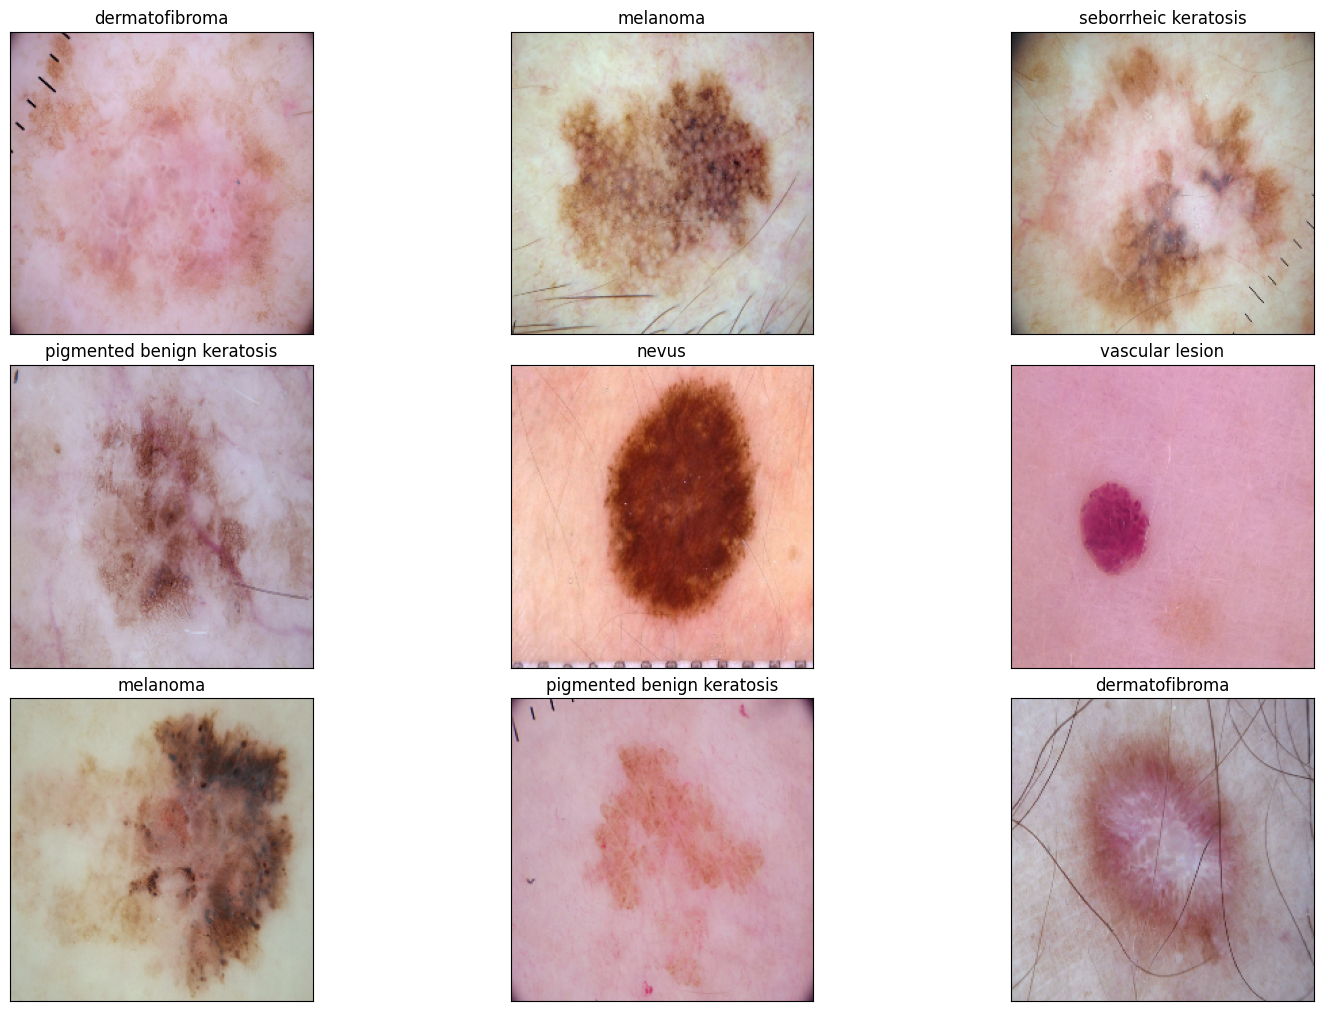

In [12]:
class_names = train_data.class_names

for batch_images, batch_labels in train_data:
    break

fig, ax = plt.subplots(3, 3, figsize=(15, 10), constrained_layout=True)

image_index = 0
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(batch_images[image_index].numpy()/255.)
        ax[i, j].set_title(class_names[batch_labels[image_index].numpy().argmax()])
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        image_index += 1

plt.show()

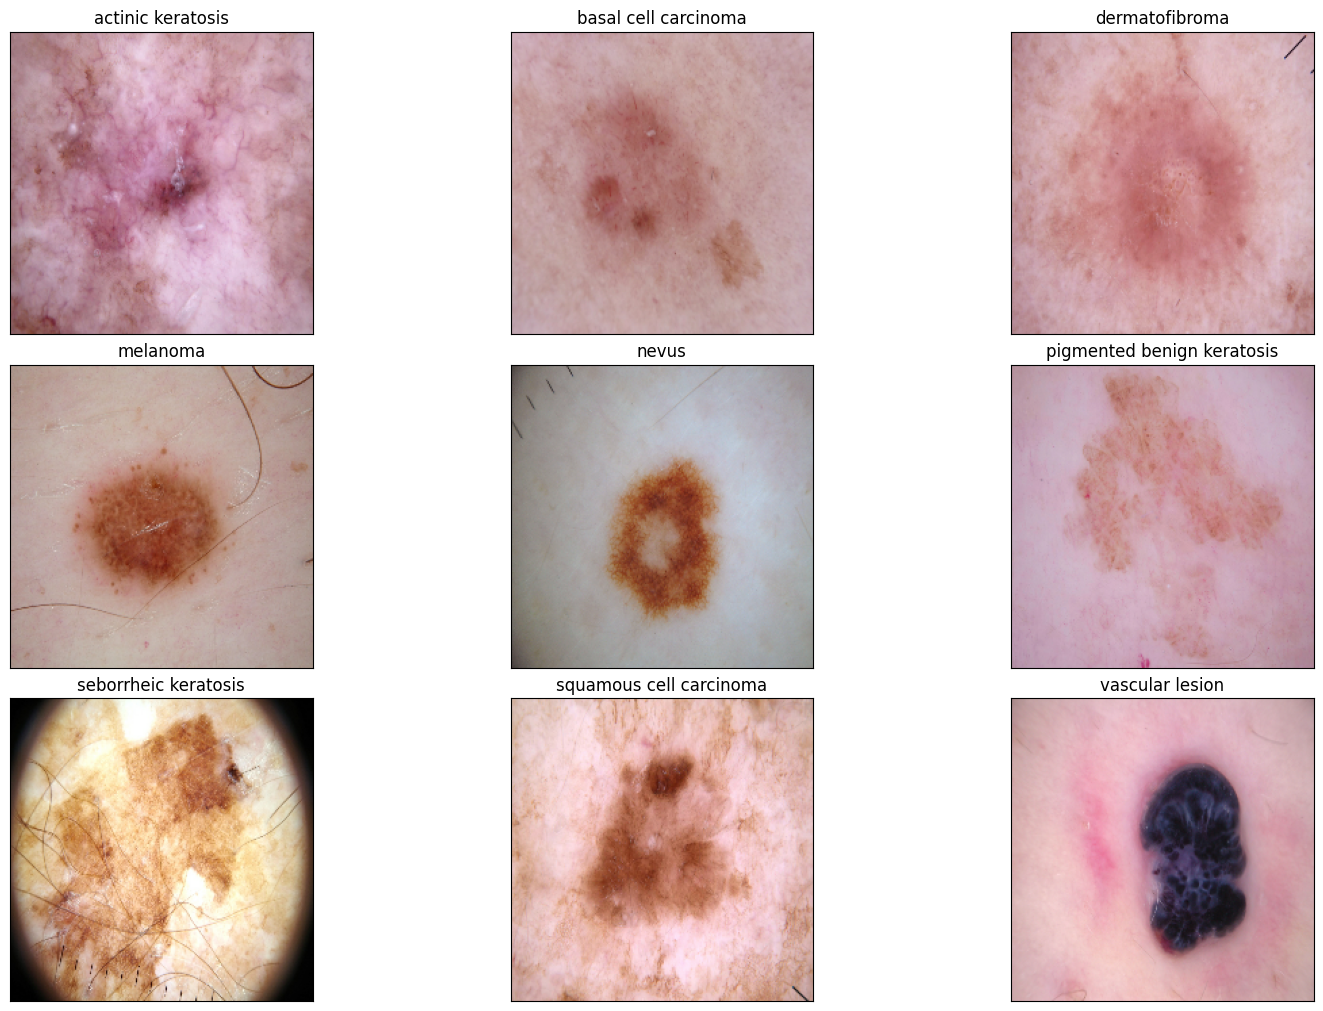

In [13]:
#Printing a sample of each class
num_classes = len(class_names)

# Create a dictionary to store the first image for each class
class_images = {class_name: None for class_name in class_names}

# Iterate through the dataset to collect the first image for each class
for batch_images, batch_labels in train_data:
    for img, label in zip(batch_images, batch_labels):
        class_name = class_names[np.argmax(label)]
        if class_images[class_name] is None:
            class_images[class_name] = img.numpy()
            
        # Stop the loop if all class images have been collected
        if all(image is not None for image in class_images.values()):
            break
    if all(image is not None for image in class_images.values()):
        break

# Plot the collected images
fig, ax = plt.subplots(3, 3, figsize=(15, 10), constrained_layout=True)

image_index = 0
for i in range(3):
    for j in range(3):
        class_name = class_names[image_index]
        ax[i, j].imshow(class_images[class_name] / 255.)
        ax[i, j].set_title(class_name)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        image_index += 1

plt.show()

In [14]:
#Creating an augmentation model

augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1/255.),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
])

In [15]:
#We will be using a Transfer Learning Model for Image Classification

base_model = tf.keras.applications.ResNet101(weights=None,input_shape = (224,224,3), include_top = False)
base_model.trainable = True

input_layer = tf.keras.layers.Input(shape = (224,224,3))

x = augmentation(input_layer)
x = base_model(x, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

output_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(input_layer, output_layer)

In [17]:
#Compiling the model

model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              ,metrics = ['accuracy']
              )

In [18]:
#Setting up callbacks

log_dir = "logs/fit/" + 'ResNet101' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
model_history = model.fit(train_data, validation_data = test_data, epochs = 10, callbacks = [tensorboard_callback])

Epoch 1/10
70/70 [==============================] - 85s 917ms/step - loss: 1.9456 - accuracy: 0.3225 - val_loss: 2.4482 - val_accuracy: 0.1525
Epoch 2/10
70/70 [==============================] - 53s 743ms/step - loss: 1.6898 - accuracy: 0.3971 - val_loss: 2.3498 - val_accuracy: 0.1864
Epoch 3/10
70/70 [==============================] - 47s 662ms/step - loss: 1.6414 - accuracy: 0.4060 - val_loss: 2.5377 - val_accuracy: 0.1780
Epoch 4/10
70/70 [==============================] - 43s 599ms/step - loss: 1.6155 - accuracy: 0.4212 - val_loss: 2.4426 - val_accuracy: 0.2627
Epoch 5/10
70/70 [==============================] - 46s 641ms/step - loss: 1.5602 - accuracy: 0.4270 - val_loss: 2.4936 - val_accuracy: 0.2458
Epoch 6/10
70/70 [==============================] - 39s 539ms/step - loss: 1.5408 - accuracy: 0.4386 - val_loss: 2.3415 - val_accuracy: 0.2627
Epoch 7/10
70/70 [==============================] - 40s 550ms/step - loss: 1.5274 - accuracy: 0.4431 - val_loss: 2.4396 - val_accuracy: 0.2881

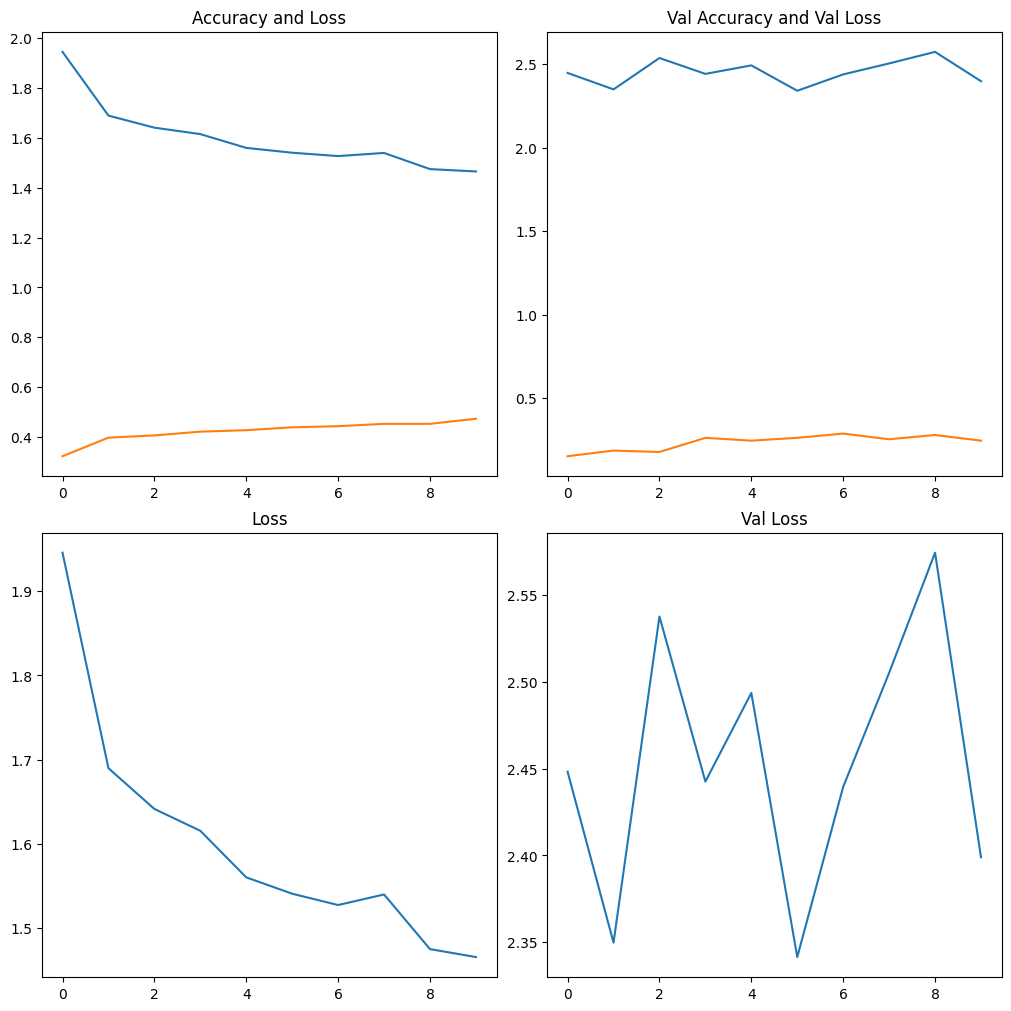

In [20]:
fig, ax  = plt.subplots(nrows=2, ncols=2, figsize=(10,10), layout='constrained')

ax[0,0].plot(pd.DataFrame(model_history.history).drop(['val_loss', 'val_accuracy'], axis=1))
ax[0,0].set(title='Accuracy and Loss')
ax[0,1].plot(pd.DataFrame(model_history.history).drop(['loss', 'accuracy'], axis=1))
ax[0,1].set(title='Val Accuracy and Val Loss')
ax[1,0].plot(pd.DataFrame(model_history.history).drop(['val_loss', 'val_accuracy', 'accuracy'], axis=1))
ax[1,0].set(title='Loss')
ax[1,1].plot(pd.DataFrame(model_history.history).drop(['loss', 'accuracy', 'val_accuracy'], axis=1))
ax[1,1].set(title='Val Loss');

>There are clear indications that the model is overfitting on our training data, while failing to find patterns in our test data.

In [21]:
preds = model.predict(test_data)
preds = np.round(preds)
y_preds = []
for pred in preds:
  y_preds.append(pred.argmax())

4/4 [==============================] - 6s 1s/step


In [22]:
y_true = []

for _, batch_labels in test_data.unbatch():
  y_true.append(batch_labels.numpy().argmax())

In [23]:
print(classification_report(y_true, y_preds));

              precision    recall  f1-score   support

           0       0.10      0.56      0.17        16
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        16
           3       0.33      0.19      0.24        16
           4       0.20      0.06      0.10        16
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00        16
           8       0.50      0.33      0.40         3

    accuracy                           0.12       118
   macro avg       0.13      0.13      0.10       118
weighted avg       0.10      0.12      0.08       118



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
mat = confusion_matrix(y_true, y_preds)

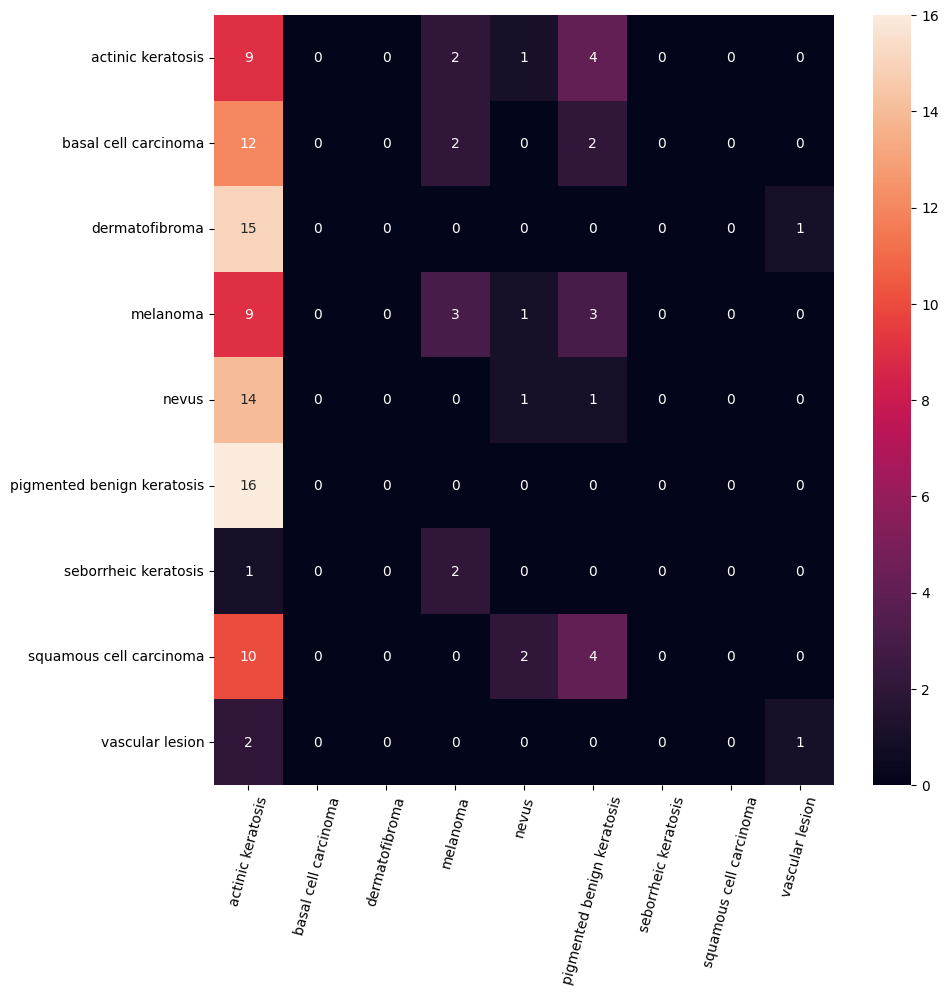

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(mat, annot=True)
ax.set_yticklabels(class_names, rotation=0)
ax.set_xticklabels(class_names, rotation=75);

1/1 [==============================] - 2s 2s/step


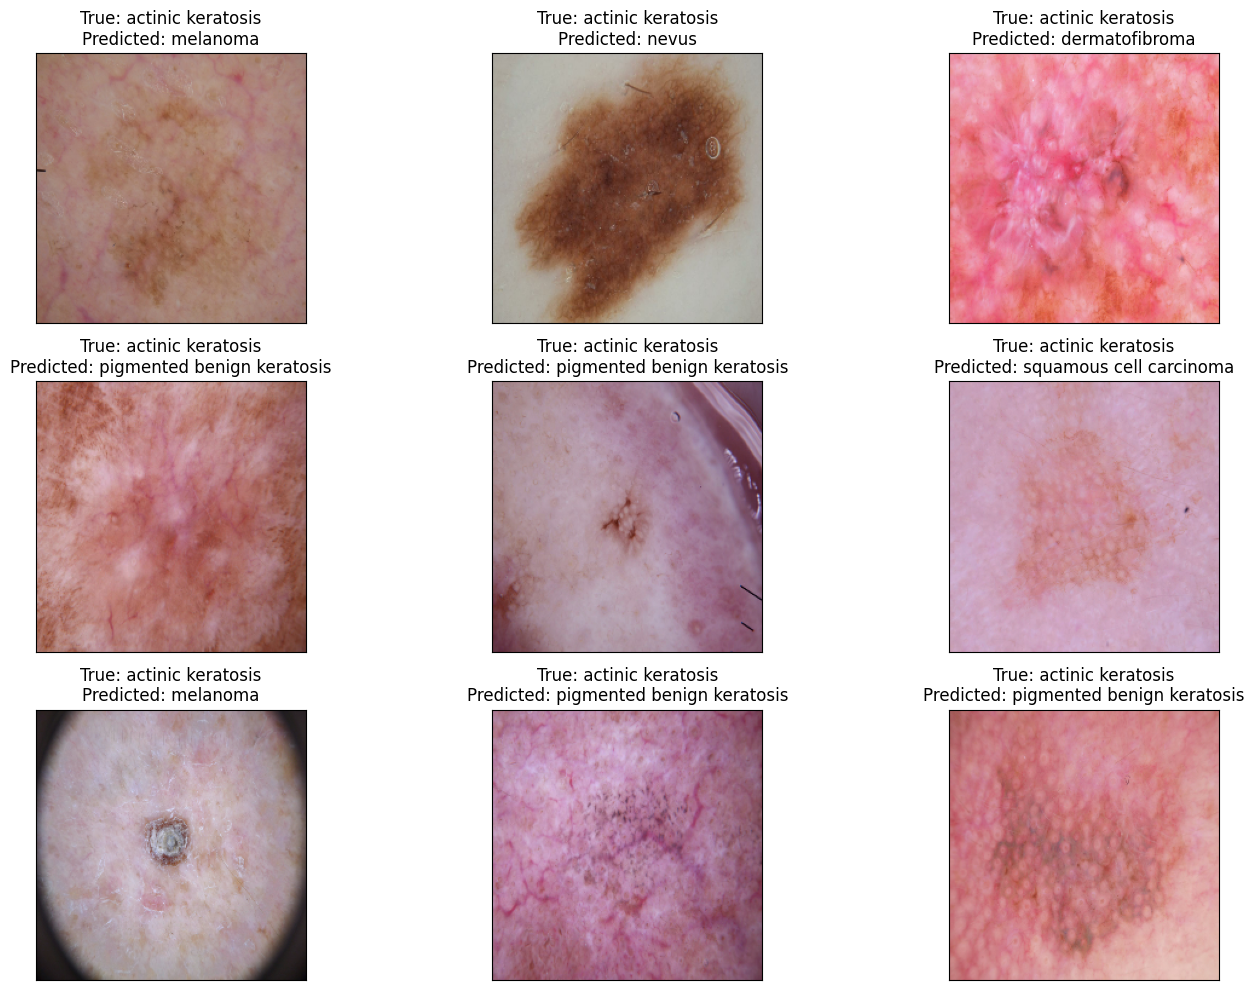

In [26]:
for batch_images, batch_labels in test_data.take(1):
    break

# Predict labels for the batch of images
predicted_probs = model.predict(batch_images)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Get true labels
true_labels = np.argmax(batch_labels.numpy(), axis=1)

# Plot the images with true and predicted labels as the title
fig, ax = plt.subplots(3, 3, figsize=(15, 10))

for i in range(3):
    for j in range(3):
        index = i * 3 + j
        ax[i, j].imshow(batch_images[index].numpy() / 255.)
        ax[i, j].set_title(f"True: {class_names[true_labels[index]]}\nPredicted: {class_names[predicted_labels[index]]}")
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.tight_layout()
plt.show()


#Predicting on mine and my friends pictures

In [51]:
image_path1 = 'IMG_4172.png'
image_path2 = 'IMG_4173.png'

load_image = plt.imread(image_path1)
load_image1 = plt.imread(image_path2)

load_image = tf.constant(load_image)
load_image = tf.image.resize(load_image, (224,224))

load_image1 = tf.constant(load_image1)
load_image1 = tf.image.resize(load_image1, (224,224))

prediction = model.predict(tf.expand_dims(load_image, axis=0))
prediction1 = model.predict(tf.expand_dims(load_image1, axis=0))

1/1 [==============================] - 0s 29ms/step


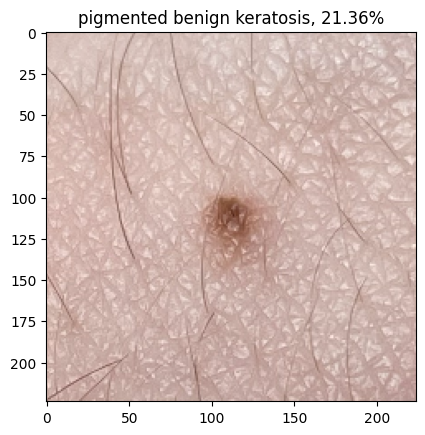

In [104]:
plt.imshow(load_image)
plt.title(f"{class_names[prediction.argmax()]}, {format(prediction.max()*100, '.2f')}%");

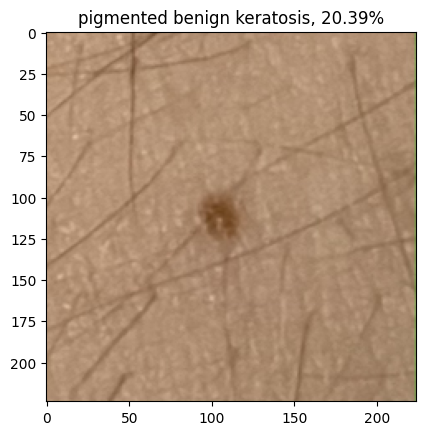

In [105]:
plt.imshow(load_image1)
plt.title(f"{class_names[prediction1.argmax()]}, {format(prediction1.max()*100, '.2f')}%");

In [54]:
predicted_probs = model.predict(test_data)

4/4 [==============================] - 6s 2s/step


In [79]:
batch_images1 = []

for batch_images2, batch_labels in test_data.unbatch():
  batch_images1.append(batch_images2)

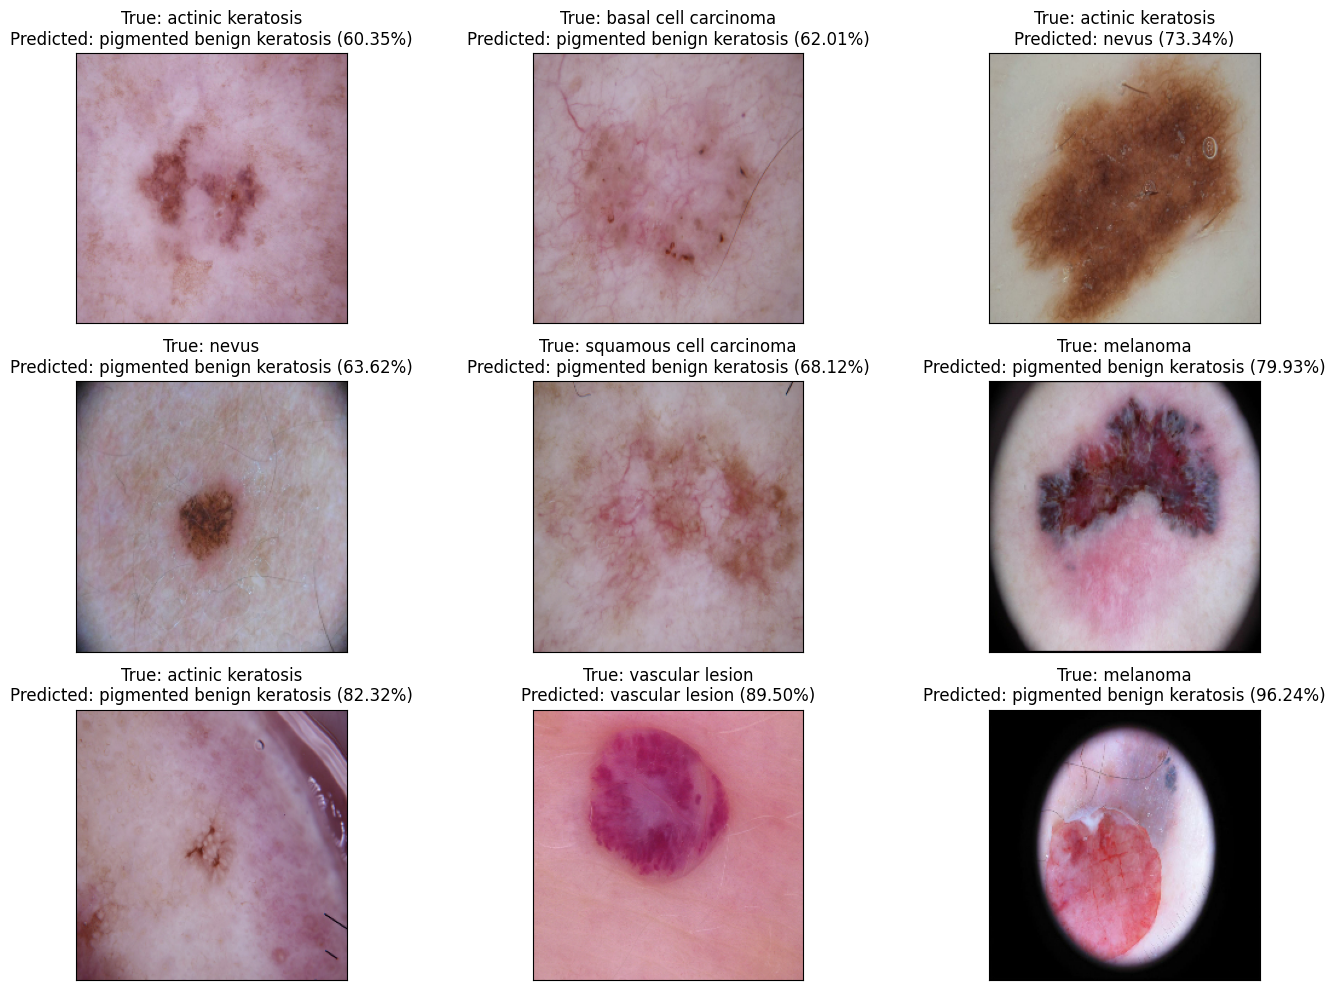

In [82]:
true_labels = y_true
predicted_labels = y_preds

# Calculate the difference between the highest and second-highest probabilities
prob_diffs = np.sort(predicted_probs, axis=1)[:, -1] - np.sort(predicted_probs, axis=1)[:, -2]

# Get the indices of the top N instances with the highest probability differences
N = 9  # Number of instances to plot
top_N_indices = np.argsort(prob_diffs)[-N:]

# Plot the top N most wrong predictions
fig, ax = plt.subplots(3, 3, figsize=(15, 10))

for i in range(3):
    for j in range(3):
        index = i * 3 + j
        instance_index = top_N_indices[index]
        pred_prob = predicted_probs[instance_index, predicted_labels[instance_index]] * 100
        ax[i, j].imshow(batch_images1[instance_index].numpy()/255.)
        ax[i, j].set_title(f"True: {class_names[true_labels[instance_index]]}\nPredicted: {class_names[predicted_labels[instance_index]]} ({pred_prob:.2f}%)")
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.tight_layout()
plt.show()


In [120]:
#Saving the model

model.save('/content/drive/MyDrive/ResNet101_SkinCancerClassification.h5')

#Conclusion

> The model used was a totally fresh ResNet101, which yieled about 20% accuracy after 10 epochs of training, the accuracy could be improved if the model is trained for longer, or the problem is reformulated into a binary classification task, like for example Benign or Not, as many of the patterns are similar, which makes it much harder for the model to correctly predict for multiple classes.